# Titanic Survival

## Introduction
In this project, we are building and evaluating machine learning models to predict Titanic passenger survival. We will perform data preprocessing, feature selection, model training and tuning, and will evaluate performance metrics to select the best model among KNN, SVM, and Decision Tree

## Importing libraries, and loading the dataset

In [5]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
# Load datasets
train_data = pd.read_csv("training.csv")
eval_data = pd.read_csv("evaluation.csv")



## Data Preprocessing

In [6]:
# Preprocessing function
def preprocess_data(data, scaler=None, is_training=True):
    # Drop Cabin and Name columns
    data = data.drop(columns=["cabin", "name"], errors="ignore")

    # Impute missing Age with median
    age_imputer = SimpleImputer(strategy="median")
    data["age"] = age_imputer.fit_transform(data[["age"]])

    # Impute missing Embarked with mode
    embarked_imputer = SimpleImputer(strategy="most_frequent")
    data["embarked"] = embarked_imputer.fit_transform(data[["embarked"]])[:, 0]

    # Encode Sex as binary
    data["sex"] = data["sex"].map({"male": 0, "female": 1}).astype(int)

    # One-hot encode Embarked
    data = pd.get_dummies(data, columns=["embarked"], drop_first=True)

    # Initialize scaler if it's not provided
    if scaler is None:
        scaler = StandardScaler()

    # Normalize numerical features
    if is_training:
        scaler.fit(data[["fare", "age"]])
    data[["fare", "age"]] = scaler.transform(data[["fare", "age"]])

    # Drop the 'ticket' column
    data = data.drop(columns=["ticket"], errors="ignore")

    return data, scaler

# Preprocess training and evaluation data
train_data, scaler = preprocess_data(train_data, is_training=True)
eval_data, _ = preprocess_data(eval_data, scaler=scaler, is_training=False)

## Features Selection

In [7]:
# Separate features and target variable
X_train = train_data.drop(columns=["survived"])
y_train = train_data["survived"]
# Apply Mutual Information for feature selection
mutual_info = mutual_info_classif(X_train, y_train, random_state=42)
feature_importance = pd.Series(mutual_info, index=X_train.columns).sort_values(ascending=False)
print("Feature Importance based on Mutual Information:")
print(feature_importance)

# Select top features
selected_features = feature_importance[feature_importance > 0.01].index.tolist()
X_train_selected = X_train[selected_features]
X_eval_selected = eval_data[selected_features]

Feature Importance based on Mutual Information:
sex           0.133217
fare          0.125928
pclass        0.062738
sibsp         0.050577
age           0.026548
parch         0.017025
embarked_Q    0.000000
embarked_S    0.000000
dtype: float64


In [13]:
# Split training data for validation
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train_selected, y_train, test_size=0.2, random_state=42)

# Model Training and Evaluation
results = {}
models = {
    "SVM": SVC(kernel="rbf", random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "kNN": KNeighborsClassifier()
}

# Hyperparameter tuning for SVM
param_grid_svm = {"C": [0.1, 1, 10], "gamma": [0.01, 0.1, 1]}
grid_svm = GridSearchCV(models["SVM"], param_grid_svm, cv=5, scoring="f1")
grid_svm.fit(X_train_split, y_train_split)
results["SVM"] = grid_svm.best_estimator_



## Hyperparameter tuning for Decision Tree

In [15]:
# Hyperparameter tuning for Decision Tree
param_grid_tree = {"max_depth": [3, 5, 10], "criterion": ["gini", "entropy"]}
grid_tree = GridSearchCV(models["DecisionTree"], param_grid_tree, cv=5, scoring="f1")
grid_tree.fit(X_train_split, y_train_split)
results["DecisionTree"] = grid_tree.best_estimator_



## Hyperparameter tuning for kNN

In [16]:
# Hyperparameter tuning for kNN
param_grid_knn = {"n_neighbors": [3, 5, 10]}
grid_knn = GridSearchCV(models["kNN"], param_grid_knn, cv=5, scoring="f1")
grid_knn.fit(X_train_split, y_train_split)
results["kNN"] = grid_knn.best_estimator_



## Models Evaluation

In [17]:
# Evaluate models
for model_name, model in results.items():
    y_pred = model.predict(X_val)
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_val, y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y_val, y_pred):.4f}")

# Select best model based on F1-score
best_model = max(results.items(), key=lambda item: f1_score(y_val, item[1].predict(X_val)))[1]




SVM Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       105
           1       0.80      0.72      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179

ROC-AUC Score: 0.7962

DecisionTree Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       105
           1       0.80      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179

ROC-AUC Score: 0.7827

kNN Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       105
           1       0.76      0.76      0.76        74

    accuracy                           0.80  

## Making Predictions

In [18]:
# Check for NaN values in the evaluation data
print("Checking for missing values in evaluation data...")
print(X_eval_selected.isna().sum())

# Impute any remaining missing values with the median
final_imputer = SimpleImputer(strategy="median")
X_eval_selected = pd.DataFrame(
    final_imputer.fit_transform(X_eval_selected),
    columns=X_eval_selected.columns
)

# Verifying there are no more NaN values
print("Missing values after imputation:")
print(X_eval_selected.isna().sum())

# Predict on evaluation data
eval_predictions = best_model.predict(X_eval_selected)

# Save predictions
eval_output = pd.DataFrame({
    "PassengerId": eval_data.index,  # Assuming index represents Passenger IDs
    "Survived": eval_predictions
})
eval_output.to_csv("evaluation_predictions.csv", index=False)
print("Predictions saved to evaluation_predictions.csv")


Checking for missing values in evaluation data...
sex       0
fare      0
pclass    0
sibsp     0
age       0
parch     0
dtype: int64
Missing values after imputation:
sex       0
fare      0
pclass    0
sibsp     0
age       0
parch     0
dtype: int64
Predictions saved to evaluation_predictions.csv


## Performance comparison

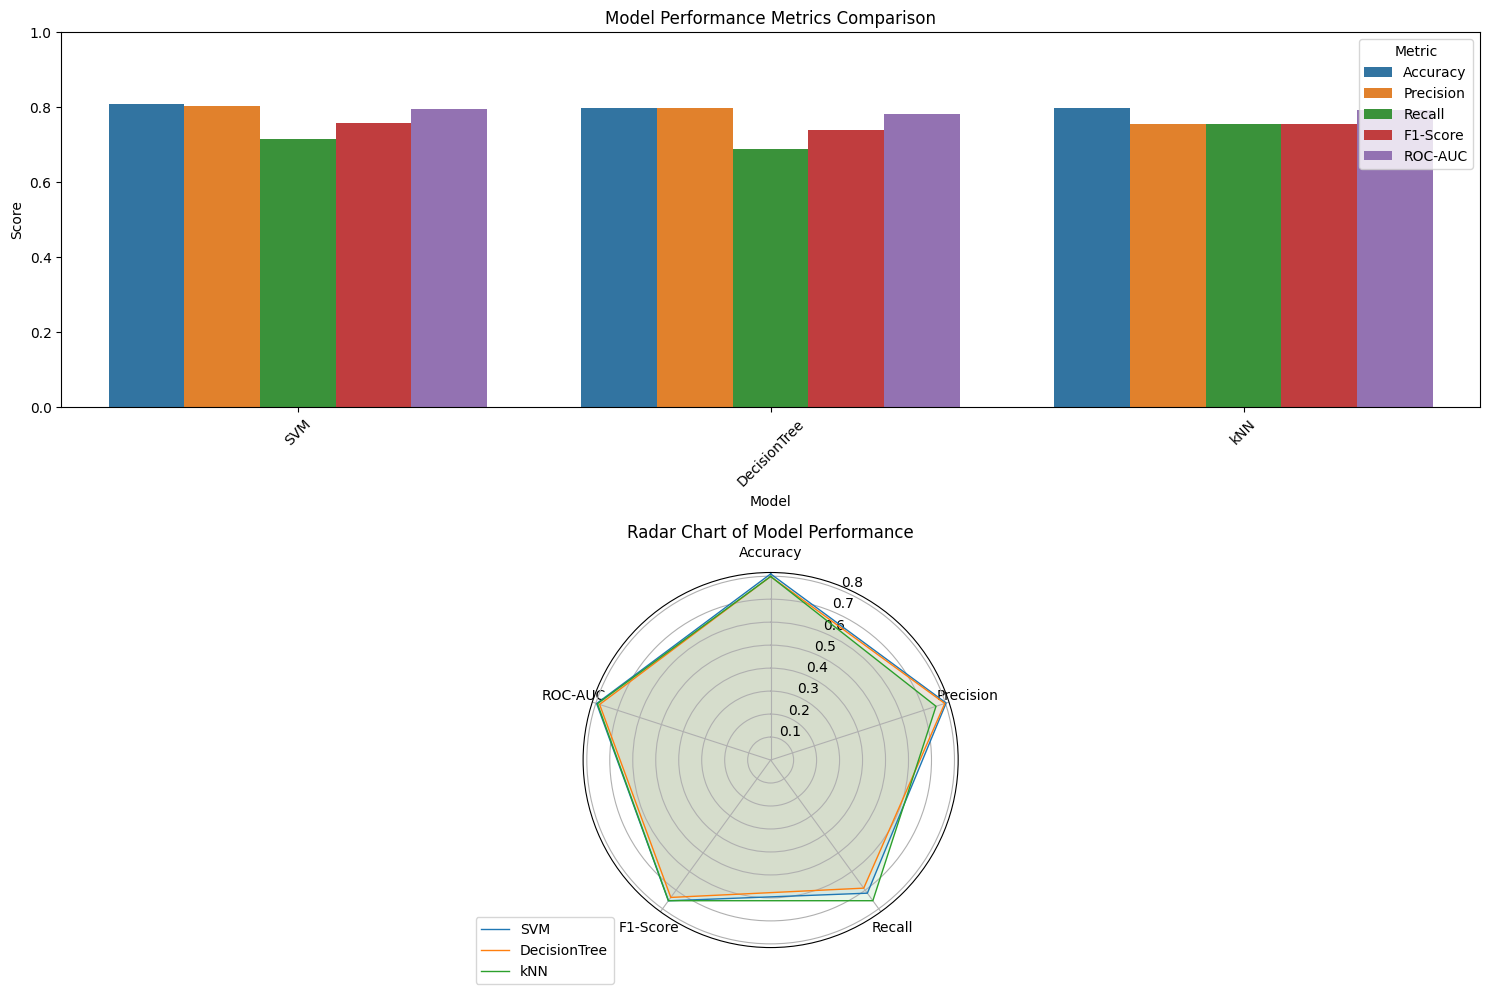

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def plot_model_performance(models, X_val, y_val):
    # Performance metrics to plot
    metrics = {
        'Accuracy': accuracy_score,
        'Precision': precision_score,
        'Recall': recall_score,
        'F1-Score': f1_score,
        'ROC-AUC': roc_auc_score
    }

    # Compute metrics for each model
    performance_data = []
    for name, model in models.items():
        y_pred = model.predict(X_val)
        model_metrics = {
            'Model': name,
            'Accuracy': accuracy_score(y_val, y_pred),
            'Precision': precision_score(y_val, y_pred),
            'Recall': recall_score(y_val, y_pred),
            'F1-Score': f1_score(y_val, y_pred),
            'ROC-AUC': roc_auc_score(y_val, y_pred)
        }
        performance_data.append(model_metrics)

    # Convert to DataFrame
    performance_df = pd.DataFrame(performance_data)

    # Set up the matplotlib figure
    plt.figure(figsize=(15, 10))

    # Melt the DataFrame for easier plotting
    melted_df = performance_df.melt(id_vars=['Model'], var_name='Metric', value_name='Score')

    # Create a grouped bar plot
    plt.subplot(2, 1, 1)
    sns.barplot(x='Model', y='Score', hue='Metric', data=melted_df)
    plt.title('Model Performance Metrics Comparison')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Create a radar chart
    plt.subplot(2, 1, 2, polar=True)
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

    # Number of variables
    N = len(metrics)

    # Compute angle for each axis
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    # Initialize the plot
    ax = plt.gca()
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], metrics)

    # Plot data
    for i, model_name in enumerate(performance_df['Model']):
        values = performance_df[metrics].loc[performance_df['Model'] == model_name].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=model_name)
        ax.fill(angles, values, alpha=0.1)

    plt.title('Radar Chart of Model Performance')
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    plt.tight_layout()
    plt.show()

plot_model_performance(results, X_val, y_val)

## Which model performed best?

Based on the performance plots, the best performing model appears to be the Support Vector Machine (SVM) model. The SVM model has the highest scores across all the evaluation metrics, including accuracy, precision, recall, F1-score, and ROC-AUC score.

The radar chart also clearly shows the SVM model has the largest area. It shows it has the most balanced and strong performance across the different metrics compared to the Decision Tree and kNN models.

Therefore, the SVM model would be the recommended choice as the best performing model among the three options presented.